In [317]:
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime, timedelta

from keras.src.losses import mean_squared_error
from matplotlib import pyplot as plt
from more_itertools import batched

from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import kpss, adfuller

from scipy.stats import boxcox

from tensorflow.keras import losses, metrics, optimizers
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall, F1Score

In [213]:
train = pd.DataFrame(pd.read_csv('data/dataset_lab3_train.csv')[['meantemp', 'date']])
test = pd.DataFrame(pd.read_csv('data/dataset_lab3_test.csv')[['meantemp', 'date']])

In [214]:
train.date = pd.to_datetime(train.date)
test.date = pd.to_datetime(test.date)

In [215]:
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

In [216]:
train = train.resample('ME').mean()
test = test.resample('ME').mean()

In [6]:
test

,meantemp
date,
2017-01-31,15.710873
2017-02-28,18.349981
2017-03-31,23.753760
2017-04-30,30.753663


In [7]:
def three_plot(data, figsize=(30, 10)):
    fig, axes = plt.subplots(3, 1)
    plt.rcParams.update({'figure.figsize': figsize, 'figure.dpi': 90})
    axes[0].plot(data)
    plot_acf(data, ax=axes[1])
    plot_pacf(data, ax=axes[2])
    plt.plot()


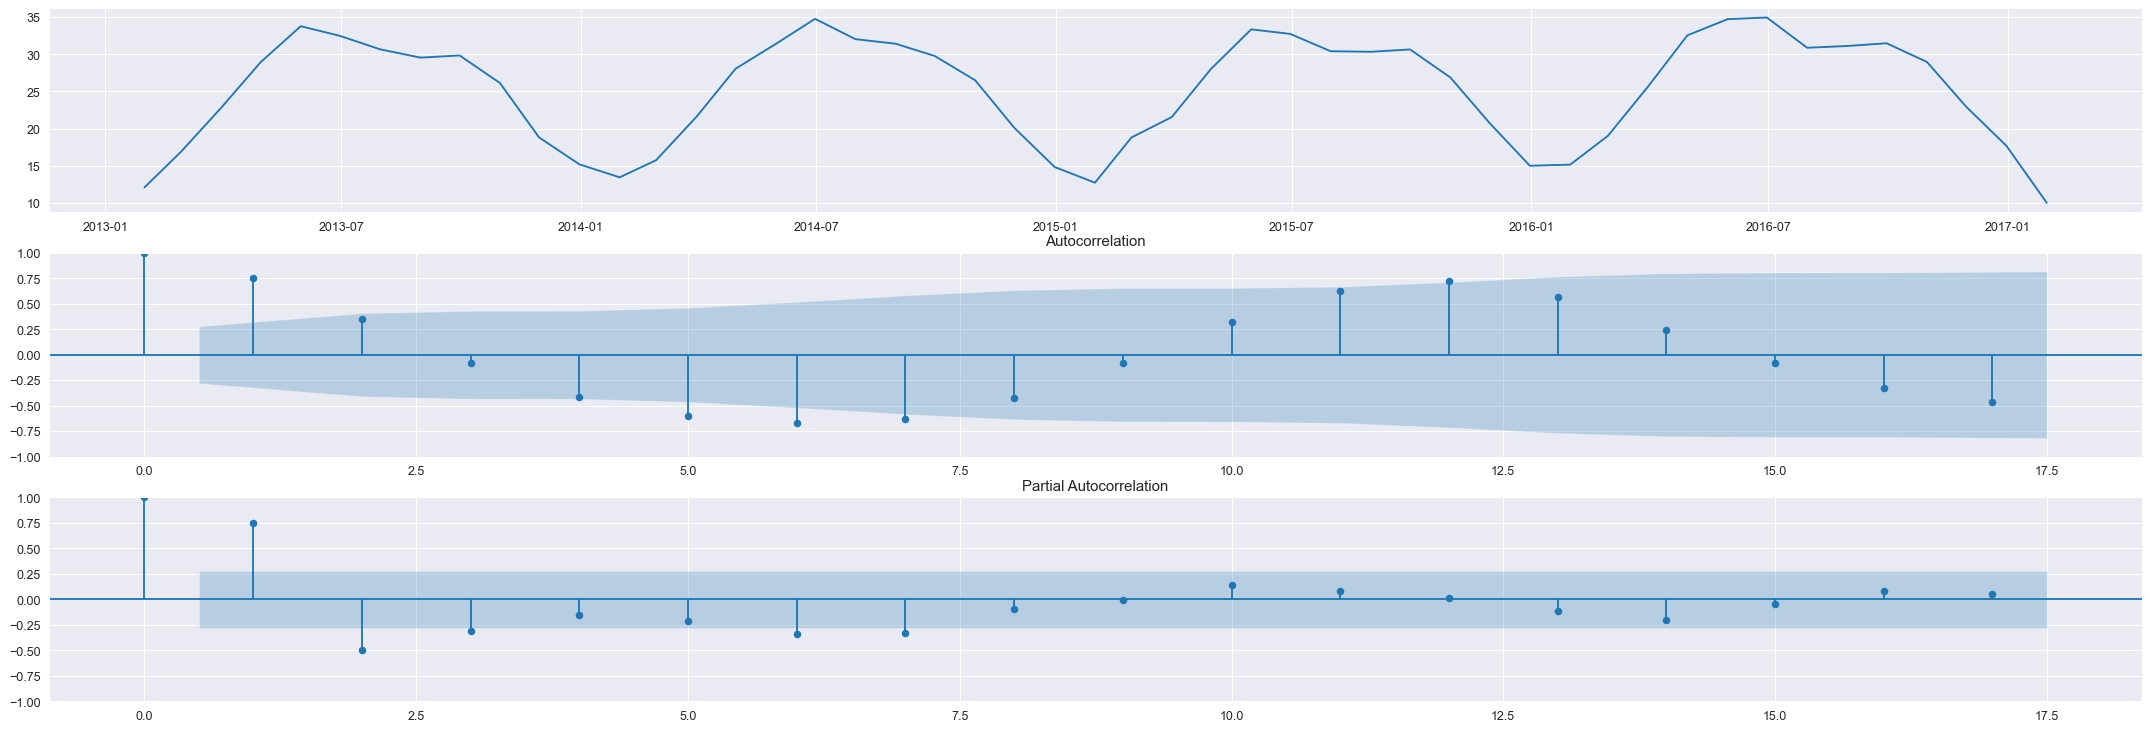

In [9]:
three_plot(train)

In [10]:
def stationary_test(data):
    p_value = adfuller(data)[1]
    is_stat = p_value > 0.05
    print(f'pvalue: {p_value} -> {"stationary" if is_stat else "non stationary"}')
    print(adfuller(data))
    return is_stat

pvalue: 0.8373097533459751 -> stationary
(-0.735606892615406, 0.8373097533459751, 10, 25, {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004}, 109.427690660211)


True

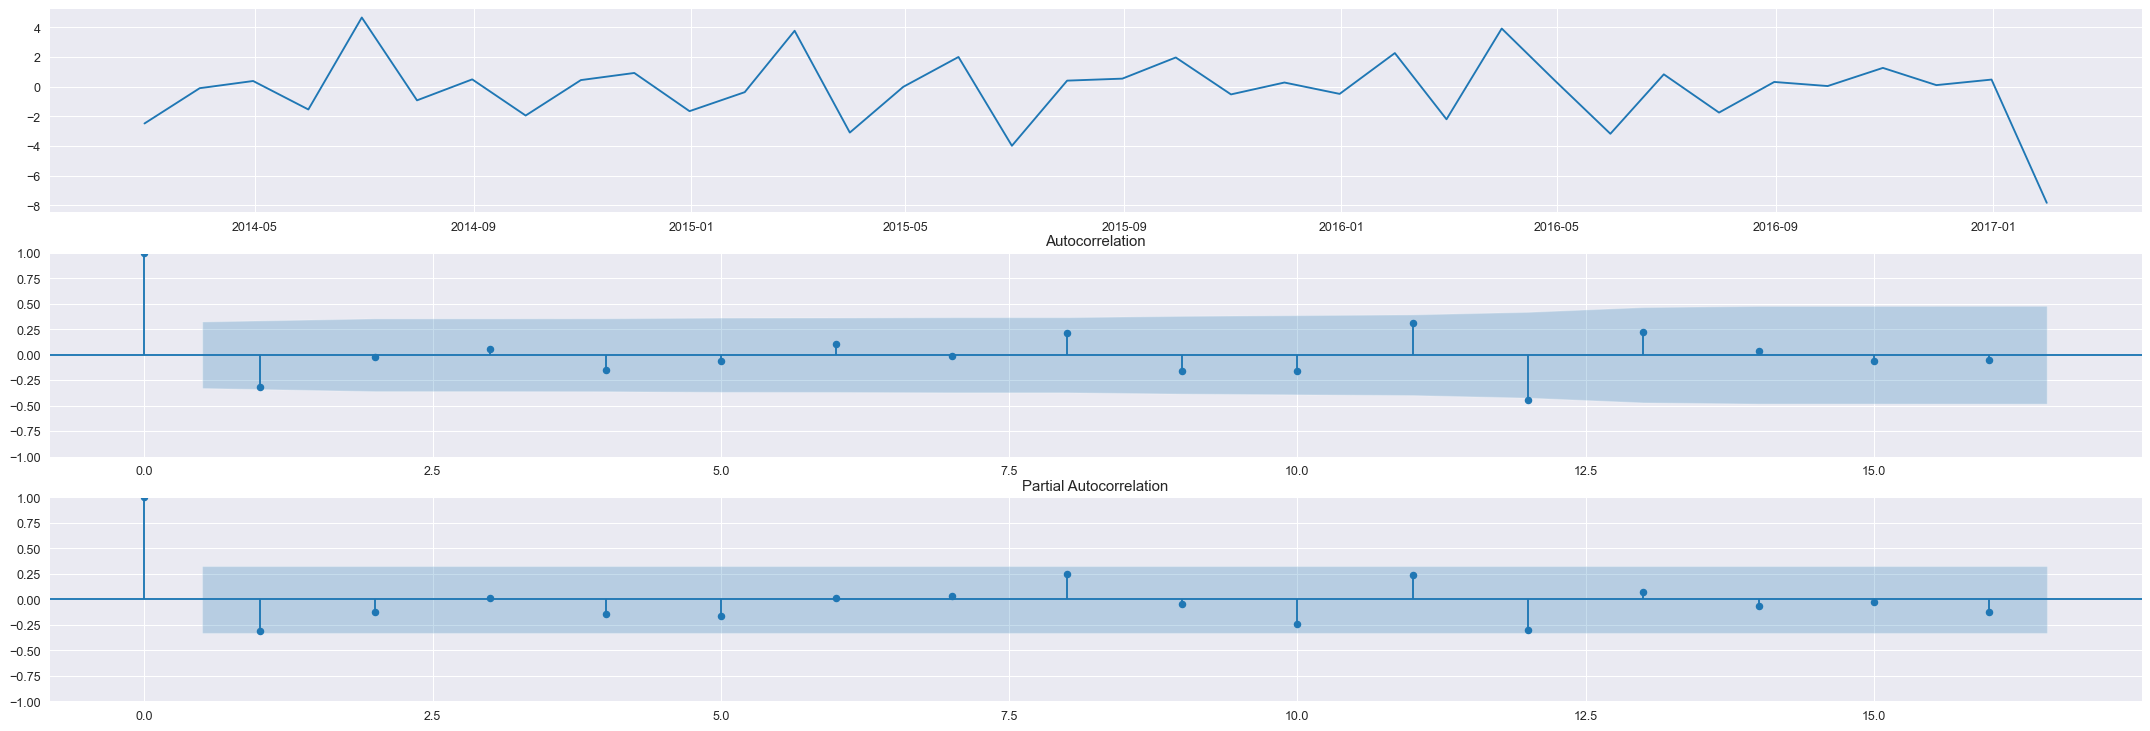

In [11]:
cox, _ = boxcox(train.meantemp)
cox = pd.DataFrame(cox)
diff_one = diff(train.meantemp, k_seasonal_diff=1, seasonal_periods=12)
three_plot(diff_one)
stationary_test(diff_one)
# print(f'pvalue: {p_value} -> {"stationary" if p_value < 0.05 else "non stationary"}')

In [12]:
arima = ARIMA(train, order=(7, 0, 7), seasonal_order=(0, 1, 1, 12)).fit()

D:\python\DataProcessingLabs\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\python\DataProcessingLabs\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\python\DataProcessingLabs\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
D:\python\DataProcessingLabs\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
preds = arima.predict(train.index[0], train.index[-1])
forecast = arima.forecast(10)

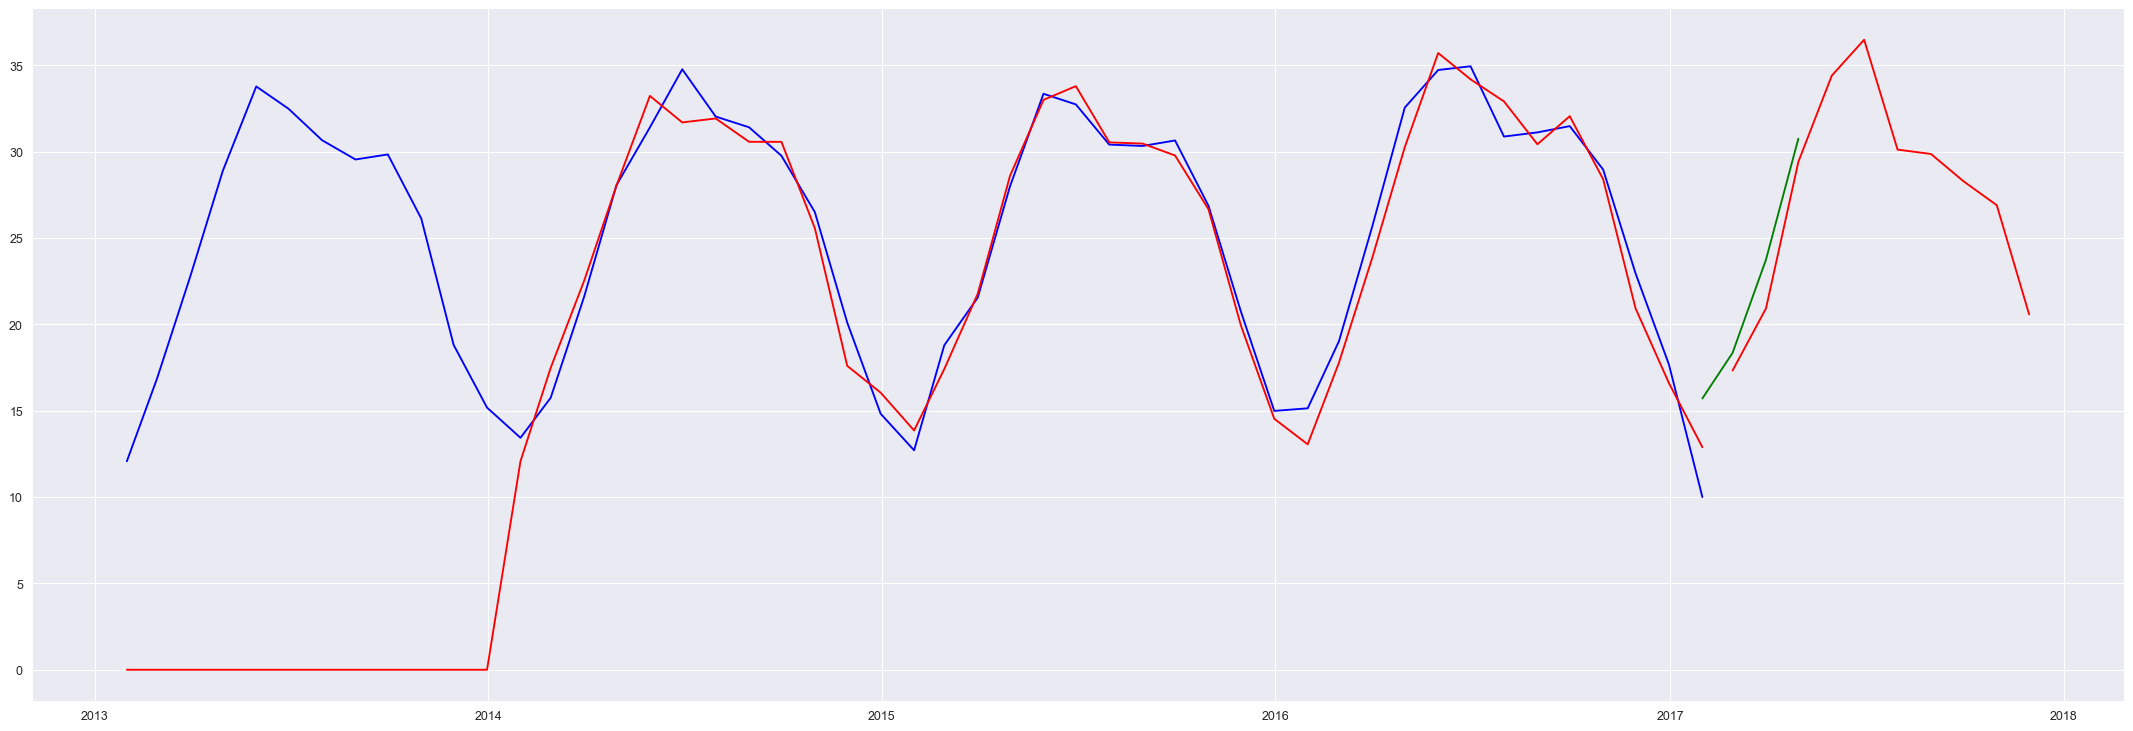

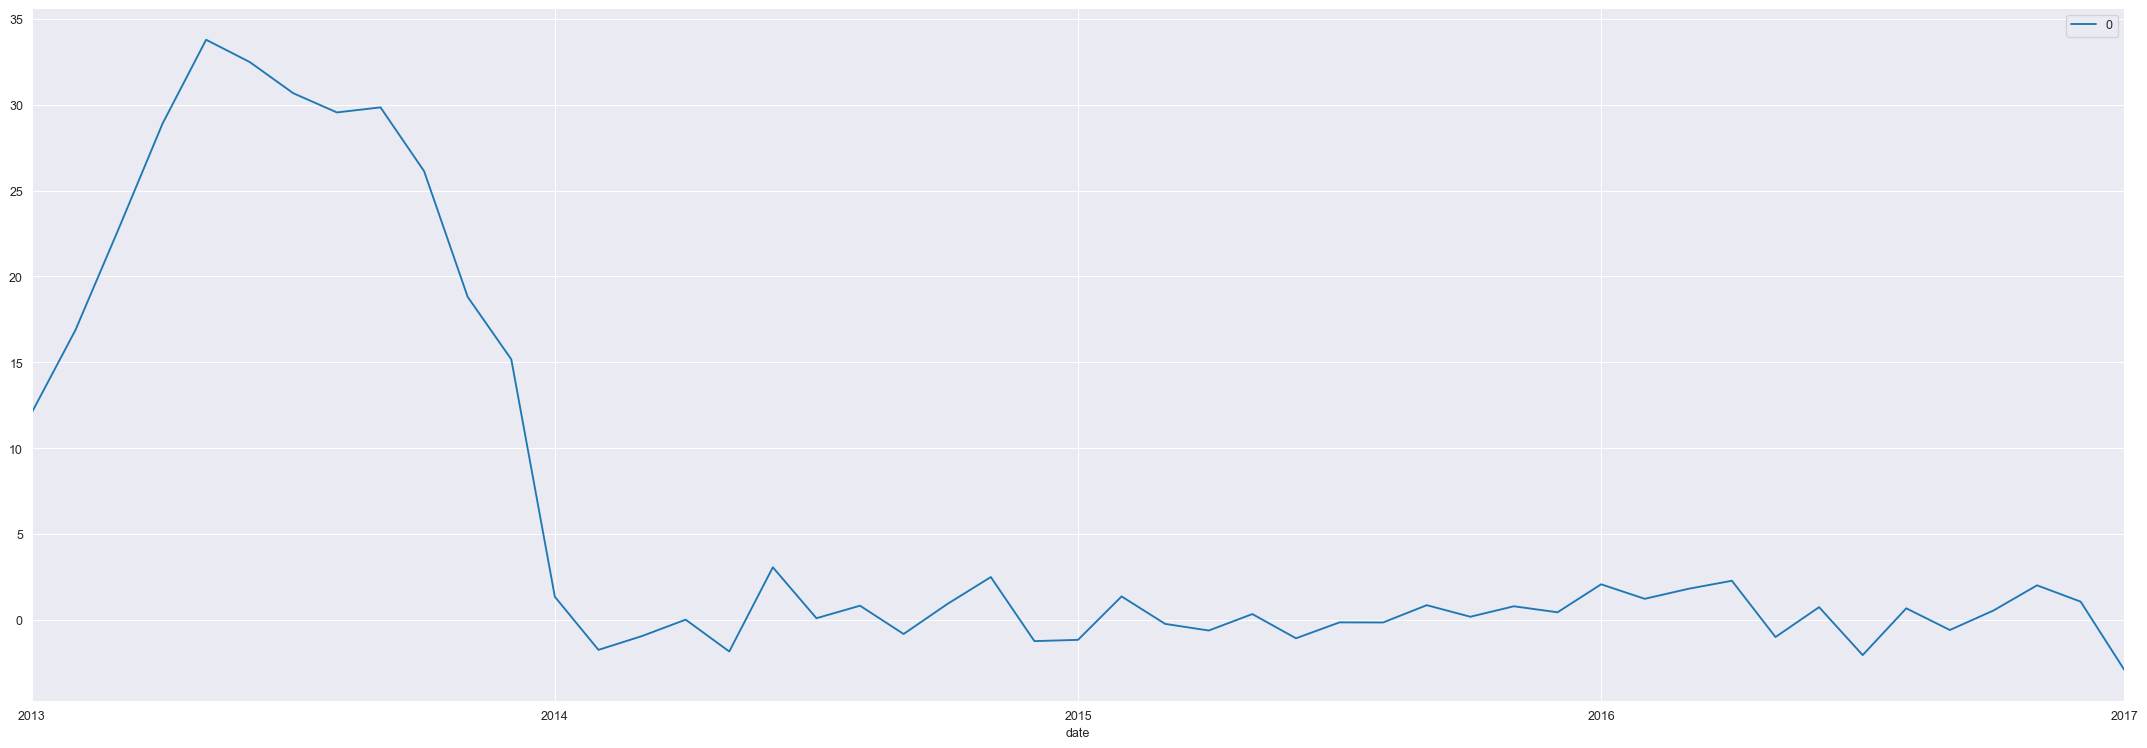

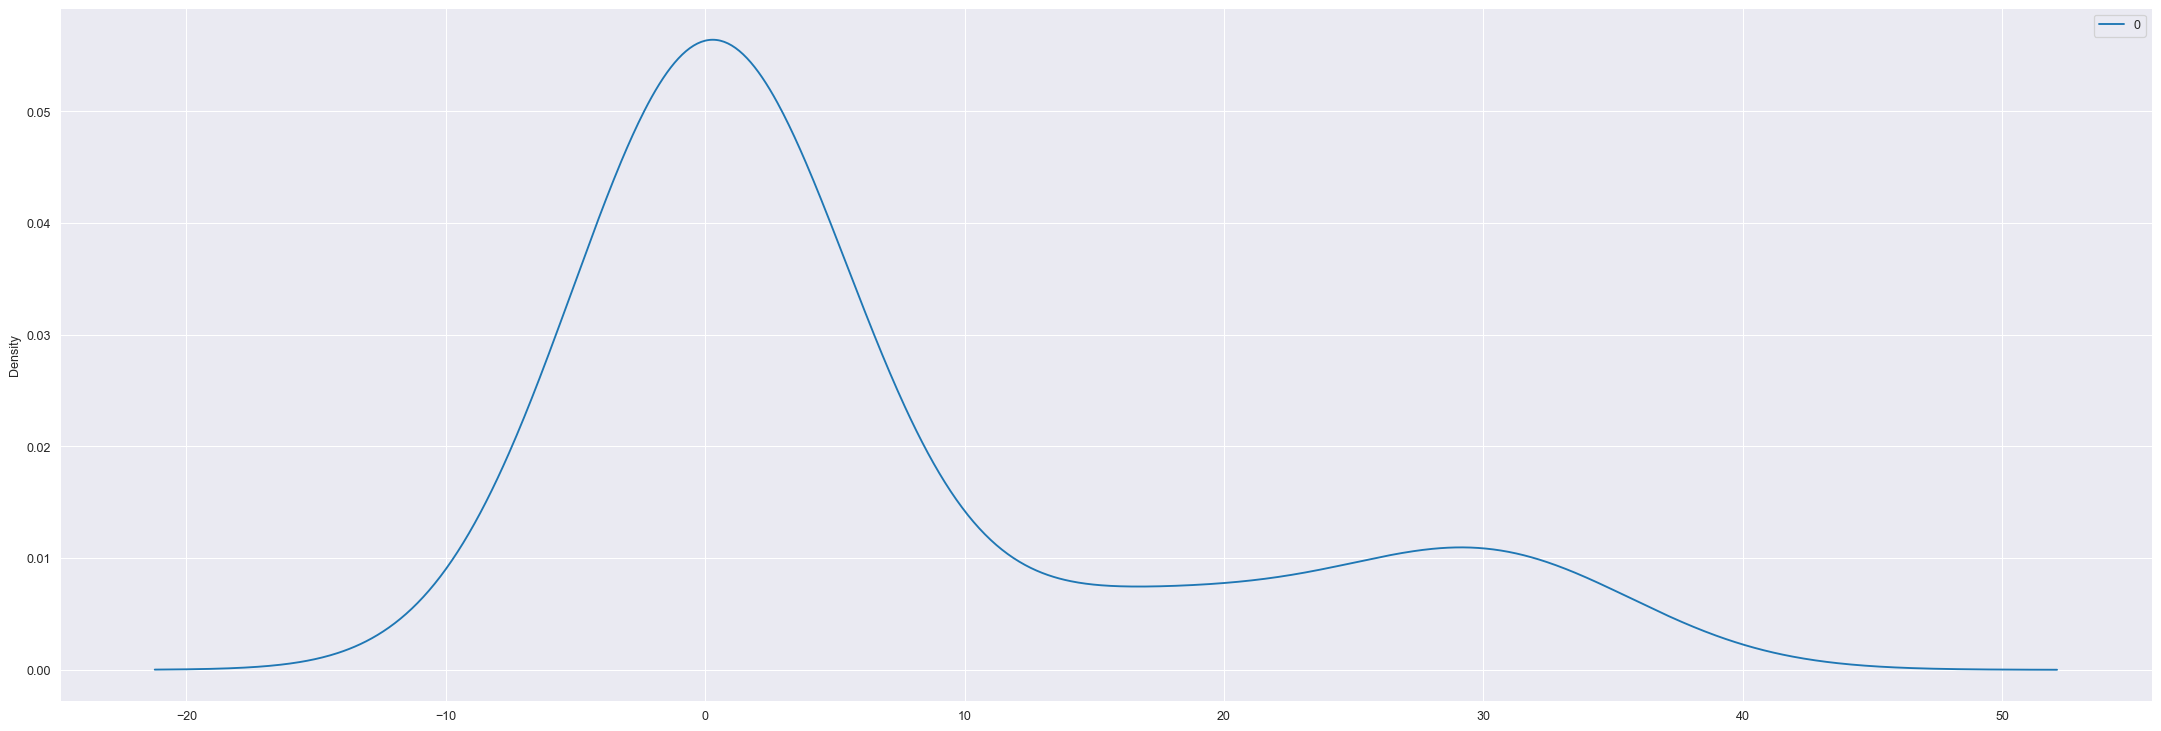

In [14]:
plt.plot(train, color='blue', label='Train')
plt.plot(test, color='green', label='Test')
plt.plot(preds, color='red', label='Preds')
plt.plot(forecast, color='red', label='Forecast')
plt.show()

# line plot of residuals
residuals = pd.DataFrame(arima.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()


array([[0.08316764],
       [0.2752878 ],
       [0.51366068],
       [0.75741545],
       [0.95309748],
       [0.90115127],
       [0.82830522],
       [0.78357723],
       [0.79531509],
       [0.64654234],
       [0.3532194 ],
       [0.20761508],
       [0.13756597],
       [0.23036233],
       [0.46472097],
       [0.72387269],
       [0.85804588],
       [0.99294489],
       [0.8832448 ],
       [0.85830395],
       [0.79218463],
       [0.66126798],
       [0.40502798],
       [0.1933605 ],
       [0.1085719 ],
       [0.35240758],
       [0.46289682],
       [0.72165369],
       [0.93609204],
       [0.91143823],
       [0.81812227],
       [0.81496464],
       [0.82776028],
       [0.67604595],
       [0.43108339],
       [0.20001059],
       [0.2060126 ],
       [0.36179643],
       [0.62938143],
       [0.9039234 ],
       [0.99125699],
       [1.        ],
       [0.83681179],
       [0.84646315],
       [0.86102174],
       [0.76008357],
       [0.51939967],
       [0.307

In [219]:
def lookback(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [393]:
train = pd.DataFrame(pd.read_csv('data/dataset_lab3_train.csv')[['meantemp', 'date']])
test = pd.DataFrame(pd.read_csv('data/dataset_lab3_test.csv')[['meantemp', 'date']])
train.date = pd.to_datetime(train.date)
test.date = pd.to_datetime(test.date)
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

look_back = 30
X_train, y_train = lookback(scaled_train, look_back)
X_test, y_test = lookback(scaled_test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [394]:
lstm = Sequential([
    LSTM(units=15, activation='relu', input_shape=(1, look_back)),
    Dense(1)
])

lstm.compile(loss='mean_squared_error',
             optimizer=optimizers.Adam())

lstm.fit(X_train, y_train, epochs=150, validation_split=0.3)


Epoch 1/150


D:\python\DataProcessingLabs\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0780 - val_loss: 0.0143
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128 - val_loss: 0.0096
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0081
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - val_loss: 0.0070
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - val_loss: 0.0057
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_loss: 0.0048
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 12/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_l

In [359]:
# make predictions
trainPredict = lstm.predict(X_train)
testPredict = lstm.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(scaler.inverse_transform([y_train])[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform([y_test])[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train Score: 1.63 RMSE
Test Score: 1.73 RMSE


In [493]:
def forecast(data, steps):
    preds = []
    for i in range(steps):
        pred = lstm.predict(data)[0,0]
        print(data)
        data = np.roll(data, -1, 2)
        data[:,:,-1] = pred
        preds.append(pred)
    return np.array(preds)
    

In [494]:
forecast_steps = 10
lstm_forecast = forecast(X_test[-1:], forecast_steps)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[[0.62663755 0.70611354 0.71834061 0.73022804 0.76419214 0.71179039
   0.75272926 0.77565502 0.72598253 0.7489083  0.76215429 0.71011085
   0.77098496 0.6419214  0.59989083 0.64574236 0.66812227 0.71069869
   0.71069869 0.72343523 0.7489083  0.77098496 0.76419214 0.81174187
   0.8558952  0.84061135 0.87117904 0.86353712 0.82227074 0.82150655]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[[0.70611354 0.71834061 0.73022804 0.76419214 0.71179039 0.75272926
   0.77565502 0.72598253 0.7489083  0.76215429 0.71011085 0.77098496
   0.6419214  0.59989083 0.64574236 0.66812227 0.71069869 0.71069869
   0.72343523 0.7489083  0.77098496 0.76419214 0.81174187 0.8558952
   0.84061135 0.87117904 0.86353712 0.82227074 0.82150655 0.82359368]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[[0.71834061 0.73022804 0.76419214 0.71179039 0.75272926 0.77565502
   0.72598253 0.7489083  0.76215429 0.71011085 0.77098496 0.6419214
   0.59989083 0.64574236 0.66812227 0.71069869 0.71069

In [495]:
inversed_lstm_forecast = scaler.inverse_transform(lstm_forecast.reshape(-1, 1))
inversed_lstm_forecast

array([[32.943275],
       [33.064365],
       [32.892582],
       [32.817226],
       [32.68395 ],
       [33.181587],
       [33.747498],
       [33.913918],
       [34.468037],
       [34.326084]], dtype=float32)

In [496]:
forecast_dates = pd.Index([test.index[-1] + timedelta(days=i) for i in range(1, forecast_steps+1)])
forecast_dates

DatetimeIndex(['2017-04-25', '2017-04-26', '2017-04-27', '2017-04-28',
               '2017-04-29', '2017-04-30', '2017-05-01', '2017-05-02',
               '2017-05-03', '2017-05-04'],
              dtype='datetime64[ns]', freq=None)

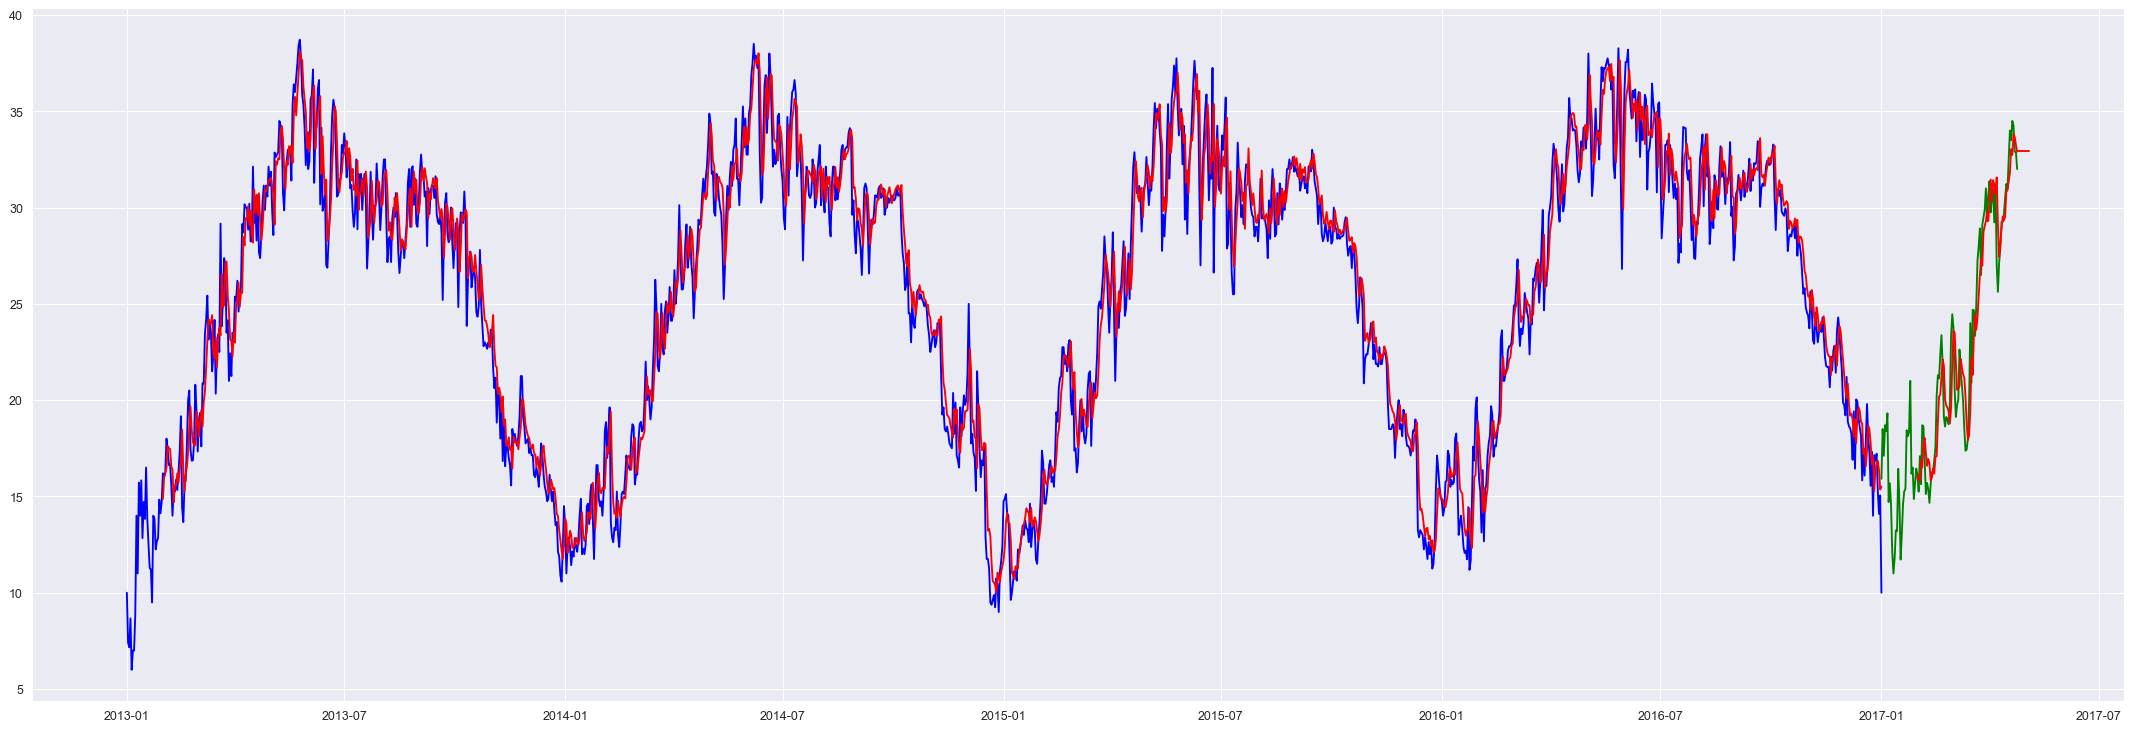

In [497]:
train_preds = pd.DataFrame({'y':trainPredict[:,0]}, index=train.index[look_back:])
test_preds = pd.DataFrame({'y':testPredict[:,0]}, index=test.index[look_back:])

df_lstm_forecast = pd.DataFrame({'y':inversed_lstm_forecast[0]}, index=forecast_dates)

plt.plot(train, color='blue', label='Train')
plt.plot(test, color='green', label='Test')
plt.plot(train_preds, color='red', label='Preds')
plt.plot(test_preds, color='red', label='Preds')
plt.plot(df_lstm_forecast, color='red', label='Preds')
plt.show()
